## AlexNet Implementation with Pre-Trained Weights

In [24]:
# This implementation is done using pytorch and is from this tutorial
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [1]:
# Helper function for finetuning in Pytorch
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [2]:
# Number of classes in the dataset
num_classes = 2
# Batch size for training, this will be used later in fine-tuning
batch_size = 8

# Number of epochs to train for this will be used later in fine-tuning
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
feature_extract = True


In [3]:

import torchvision.models as models
import torch.nn as nn

#Import the pre-trained AlexNet model
alexnet_model = models.alexnet(pretrained=True)

#Change the last layer so that the number of classes is the number of classes needed for the problem, in this case 2
alexnet_model.classifier[6] = nn.Linear(4096,num_classes)


In [4]:
# Take a look at the architecture of the model
print(alexnet_model)



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
from torchvision import transforms
from torchvision import datasets
import torch


# Transform the data to be the correct size
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


# Define the training and validation directory paths
# Note this dataset came with three folders, test, train, and val
# I got rid of the val folder which only had like 9 images and renamed the test folder val
train_dir = '/Users/mariahhurt/Desktop/chest_xray/train'
val_dir = '/Users/mariahhurt/Desktop/chest_xray/val'


# Give it the filepath to find the data and perform the specified transformations
train_image_dataset =  datasets.ImageFolder(train_dir, transform=train_transforms)

test_image_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

# This is like the flow.from.directory in keras I think
train_dataloader = torch.utils.data.DataLoader(train_image_dataset, batch_size=64, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_image_dataset, batch_size=32)

# Specify the classes
classes = ('NORMAL', 'PNEUMONIA')


## Test How AlexNet Performs on Classifying X-Rays without Fine-Tuning

In [9]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = alexnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 46 %


In [25]:
## Only an accuracy of 46% this is not unexpected since it has not trained on X-Ray data and while it may be
# good at feature extraction the classification for this particular problem is not optimized

In [10]:
# This is a way of looking at a few images and just seeing what the class labels are for them to check if
# everything is working as expected
dataiter = iter(test_dataloader)
images, labels = dataiter.next()


print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:  NORMAL NORMAL NORMAL NORMAL


## Fine-Tuning AlexNet Using X-Ray Data

In [12]:
from torch import optim
params_to_update = alexnet_model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in alexnet_model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in alexnet_model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


In [13]:
import os
data_dir = '/Users/mariahhurt/Desktop/chest_xray'
input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [14]:
import time
import copy

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
alexnet_model, hist = train_model(alexnet_model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.3508 Acc: 0.8535
val Loss: 0.4322 Acc: 0.8013

Epoch 1/9
----------
train Loss: 0.2577 Acc: 0.8936
val Loss: 0.2832 Acc: 0.9151

Epoch 2/9
----------
train Loss: 0.2481 Acc: 0.9028
val Loss: 0.2296 Acc: 0.9231

Epoch 3/9
----------
train Loss: 0.2045 Acc: 0.9174
val Loss: 0.2453 Acc: 0.8878

Epoch 4/9
----------
train Loss: 0.2043 Acc: 0.9229
val Loss: 0.2469 Acc: 0.9343

Epoch 5/9
----------
train Loss: 0.2021 Acc: 0.9170
val Loss: 0.2183 Acc: 0.9295

Epoch 6/9
----------
train Loss: 0.1826 Acc: 0.9289
val Loss: 0.1985 Acc: 0.9279

Epoch 7/9
----------
train Loss: 0.1803 Acc: 0.9302
val Loss: 0.2090 Acc: 0.9167

Epoch 8/9
----------
train Loss: 0.1745 Acc: 0.9323
val Loss: 0.1889 Acc: 0.9103

Epoch 9/9
----------
train Loss: 0.1660 Acc: 0.9350
val Loss: 0.1778 Acc: 0.9375

Training complete in 78m 2s
Best val Acc: 0.937500


In [1]:
import numpy as np
train_acc = np.array([ 0.8535,0.8936,0.9028,0.9174,0.9229,0.9170,0.9289,0.9302, 0.9323,0.9350])
test_acc = np.array([0.8013,0.9151,0.9231,0.8878,0.9343,0.9295,0.9279,0.9167,0.9103,0.9375])

In [2]:
# Plot the accuracy of the classification of the Test set over 10 Epochs
import matplotlib.pyplot as plt
acc = train_acc
val_acc = test_acc
#loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

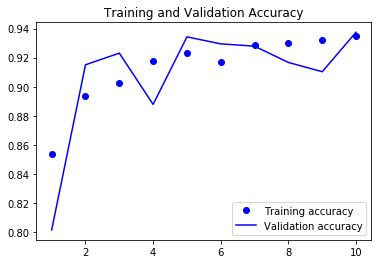

In [3]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()